# Modeling the potential of CRISPR gene drives for mosquito suppression
<hr style="border:2px solid gray"> </hr>
This notebook is for generating models with GP utilizing code generated by Sam E Champer.

First, some imports:

In [2]:
#pip install tensorflow==2.12.0

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import r2_score
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.layers import Dense, Input, Dropout, concatenate
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, reciprocal
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import seaborn as sns
from pprint import pprint
import pandas as pd
import scipy
import copy
import matplotlib.colors as colors
%matplotlib inline

<hr style="border:1px solid gray"> </hr>

## 0. Data preprocessing


In [3]:
oldnames=['malaria_takein_rate', 'malaria_sensitive', 'distance', 'remate_chance',
       'want_to_bite_rate', 'animal_bite_rate', 'dd_fitness_value',
       'somatic_fitness_multiplier_f', 'grc_beta', 'drive_conversion', 'erc_f',
       'r1_occurrence_rate', 'low_density_growth_rate', 'seasonal_amplitude',
       'cureweek', 'immunity']
newname=['transmission rate to mosquitoes', 
        'transmission rate to humans', 
        'average dispersal',
        'weekly remating chance',
        'mosquito reproduction chance', 
        'animal biting rate',
        'viability fitness', 
        'female fecundity fitness',
        'germline resistance rate',
        'drive conversion efficiency',
        'embryo resistance rate', 
        'functional resistance proportion',
        'low-density growth rate',
        'seasonal population change',
        'infection duration',
        'immunity duration']
mosquito_parameter=['average dispersal','weekly remating chance','mosquito reproduction chance','animal biting rate','viability fitness','female fecundity fitness','germline resistance rate','drive conversion efficiency',
                             'embryo resistance rate','functional resistance proportion','low-density growth rate','seasonal population change']
null_drive=['transmission rate to mosquitoes', 
        'transmission rate to humans', 
        'average dispersal',
        'weekly remating chance',
        'mosquito reproduction chance', 
        'animal biting rate',
        'low-density growth rate',
        'seasonal population change',
        'infection duration',
        'immunity duration']
malaria_only=['transmission rate to mosquitoes', 
        'transmission rate to humans', 
        'infection duration',
        'immunity duration']


In [4]:
#load the data
Train_ave=pd.read_csv('Train_ave2.csv')
Test_ave=pd.read_csv('Test_ave2.csv')

In [13]:
#normalize data
abs_scaler1 = MaxAbsScaler()
# calculate the maximum absolute value for scaling the data using the fit method
abs_scaler1.fit(Train_ave.loc[:,newname])
# the maximum absolute values calculated by the fit method
abs_scaler1.max_abs_
# transform the data using the parameters calculated by the fit method (the maximum absolute values)
scaled_data = abs_scaler1.transform(Train_ave.loc[:,newname])
# store the results in a data frame
Train_scaled = pd.DataFrame(scaled_data, columns=newname)

In [14]:

# transform the data using the parameters calculated by the fit method (the maximum absolute values)
scaled_data = abs_scaler1.transform(Test_ave.loc[:,newname])
# store the results in a data frame
Test_scaled = pd.DataFrame(scaled_data, columns=newname)

In [15]:
X_train = Train_scaled.loc[:,newname]
y_train = Train_ave.loc[:,['malaria_eliminated', 'malaria_prevalence','suppressed','mosquito_prev']]
X_test = Test_scaled.loc[:,newname]
y_test = Test_ave.loc[:,['malaria_eliminated','malaria_prevalence', 'suppressed','mosquito_prev']]

In [16]:
column_dtypes = y_train.dtypes
print(column_dtypes)

malaria_eliminated    float64
malaria_prevalence    float64
suppressed            float64
mosquito_prev         float64
dtype: object


In [17]:
X_train

,transmission rate to mosquitoes,transmission rate to humans,average dispersal,weekly remating chance,mosquito reproduction chance,animal biting rate,viability fitness,female fecundity fitness,germline resistance rate,drive conversion efficiency,embryo resistance rate,functional resistance proportion,low-density growth rate,seasonal population change,infection duration,immunity duration
0,0.191852,0.418889,0.375152,0.313,0.889,0.519,0.991,0.544,0.170971,0.820,0.188993,0.308,0.444444,0.375,0.500000,0.30
1,0.497037,0.878889,0.909697,0.673,0.290,0.285,0.987,0.671,0.789489,0.975,0.249906,0.901,0.222222,0.625,0.633333,0.15
2,0.761111,0.275556,0.745455,0.423,0.459,0.969,0.855,0.696,0.533433,0.990,0.320826,0.935,0.888889,0.875,0.600000,0.90
3,0.704074,0.404444,0.515758,0.043,0.346,0.581,0.935,0.741,0.731532,0.967,0.165979,0.613,0.666667,0.875,0.833333,0.85
4,0.464444,0.262222,0.675152,0.802,0.562,0.879,0.916,0.628,0.108008,0.918,0.275297,0.080,0.500000,1.000,0.633333,0.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9770,0.271852,0.405556,0.516364,0.886,0.768,0.066,0.886,0.635,0.788989,0.930,0.079675,0.438,0.222222,0.375,0.600000,0.60
9771,0.308519,1.000000,0.673939,0.486,0.387,0.699,0.991,0.786,0.824324,0.935,0.439024,0.619,0.888889,0.875,0.466667,0.40
9772,0.554815,0.262222,0.517576,0.833,0.514,0.160,0.817,0.822,0.787888,0.949,0.170356,0.984,0.111111,0.875,0.666667,0.15
9773,0.238148,0.722222,0.784242,0.808,0.649,0.901,0.878,0.703,0.546046,0.819,0.384740,0.263,0.111111,0.875,0.500000,0.75


<hr style="border:1px solid gray"> </hr>

## 1. load the models

Load models with 1-5layers, each model can predict the probability to eliminate malaria/eliminate mosquito and the final malaria prevalence/ mosquito density

Make a heatmap with 2 variables, 14 fixed parameters.

In [18]:
class AveragedModel:
    def __init__(self, model_files):
        self.models = [load_model(file) for file in model_files]

    def predict(self, input_data):
        # 获取所有模型的预测结果
        predictions = np.array([model.predict(input_data) for model in self.models])
        # 计算平均值
        return np.mean(predictions, axis=0)

In [19]:
model=AveragedModel(['models//DL//20241210malaria_layer3'+'rep'+str(j) for j in range(20)])
model2=AveragedModel(['models//DL//20241210mosquito_layer3'+'rep'+str(j) for j in range(20)])
model0 = keras.models.load_model('models//230511_NN_ParamRange_2')

In [20]:
data = {'Malaria takein rate':[0.11,0.05,0.27], 
        'Malaria sensitive': [0.3,0.2,0.9], 
        'Distance': [0.11,0.033,0.165],
        'Remate chance':[0.05,0,1],
        'Want to bite rate': [0.6,0.25,1], 
        'Animal bite rate': [1.0,0,1],
        'Fitness value': [1.0,0.8,1], 
        'Female Somatic fitness multiplier':[0.5,0.5,1],
        'Germline Resistance cut rate': [0.01,0,0.999],
        'Drive conversion':[0.95,0.8,1],
        'Embryo Resistance Cut Rate': [0.1,0,0.8], 
        'R1 Occurance Rate': [0.00001,-6,-3],
        'Low density growth rate': [6,2,18],
        'Seasonal amplitude':[0.5,0,0.8],
        'Weeks until curation':[15,10,30],
        'Human immunity':[5,0,20]}
data = pd.DataFrame(data)

In [21]:
new_data  = {'transmission rate to mosquitoes':[0.11,0.05,0.27], 
            'transmission rate to humans': [0.3,0.2,0.9], 
            'average dispersal': [0.11,0.033,0.165],
            'weekly remating chance':[0.05,0,1],
            'mosquito reproduction chance': [0.6,0.25,1], 
            'animal biting rate': [1.0,0,1],
            'viability fitness': [1.0,0.8,1], 
            'female fecundity fitness':[0.5,0.5,1],
            'germline resistance rate': [0.05,0,0.999],
            'drive conversion efficiency':[0.90,0.8,1],
            'embryo resistance rate': [0.15,0,0.8], 
            'functional resistance proportion': [0.00001,-6,-3],
            'low-density growth rate': [6,2,18],
            'seasonal population change':[0.5,0,0.8],
            'infection duration':[15,10,30],
            'immunity duration':[5,0,20]}
new_data = pd.DataFrame(new_data)


In [39]:
def generate_heatmap_different_bar(data, model,model2,model0,i,j,steps=10,log10=False):
    plt.rcParams['font.family'] = 'Times New Roman'
    pdf_pages = PdfPages('resistance//'+newname[i]+'-'+newname[j]+'.pdf')

    # Create a copy of the data with all inputs fixed except the two we want to vary
    fixed_inputs = data.loc[[0]].drop(data.columns[[i, j]], axis=1)
    fixed_inputs = np.tile(fixed_inputs, (steps**2, 1))
    #set a param range for the 2 params we want to vary
    x_min = data.iloc[1, i]
    x_max = data.iloc[2, i]
    x_label_min = data.iloc[1, i]
    x_label_max = data.iloc[2,i]

    y_min = data.iloc[1, j]
    y_max = data.iloc[2, j]
    y_label_min = data.iloc[1, j]
    y_label_max = data.iloc[2,j]
    
    
    name_x=data.iloc[:, i].name
    name_y=data.iloc[:, j].name
    
    # the germline resistance formation rate is the late germline resistance formation rate, if drive conversion happens, the germline resistance won't happen, here we 
    # output the proportion of resistance allele in germline so we do calculate
    if data.iloc[:, i].name=='germline resistance rate':
        if data.iloc[:, j].name!='drive conversion efficiency':
            x_label_min = round(x_label_min*(1-data['drive conversion efficiency'][0]),3)
            x_label_max = round(x_label_max*(1-data['drive conversion efficiency'][0]),3)
        else:
            name_x="late germline resistance rate"
    if data.iloc[:, j].name=='germline resistance rate':
        if data.iloc[:, i].name!='drive conversion efficiency':
            y_label_min = round(y_label_min*(1-data['drive conversion efficiency'][0]),3)
            y_label_max = round(y_label_max*(1-data['drive conversion efficiency'][0]),3)
        else:
            name_y="late germline resistance rate"

    # Create a grid of values for the two inputs we want to vary
    x = np.linspace(x_min, x_max, steps)
    y = np.linspace(y_min, y_max, steps)
    
    pref1=''
    if data.iloc[:, i].name=='functional resistance proportion':
        pref1='log$_1$$_0$ '
        x = 10**x
        name_x='functional\n resistance proportion'
    pref2=''
    if data.iloc[:, j].name=='functional resistance proportion':
        pref2='log$_1$$_0$ '
        name_y='functional\n resistance proportion'
        y = 10**y
    if name_x=="transmission rate to mosquitoes":
        name_x="transmission rate\n to mosquitoes"
    if name_y=="transmission rate to mosquitoes":
        name_y="transmission rate\n to mosquitoes"
    grid = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
    colormap=list(sns.color_palette('coolwarm',10))
    colormap.insert(0,(0.21883238319215684, 0.2266050511215686, 0.65985744820392169))
    colormap.append((0.610615674827451, 0.16879706171764706, 0.13542761153333333))
    colormapr=list(sns.color_palette('coolwarm',10))
    colormapr.insert(0,(0.21883238319215684, 0.2266050511215686, 0.65985744820392169))
    colormapr.append((0.610615674827451, 0.16879706171764706, 0.13542761153333333))
    colormapr.reverse()
    
    # Combine the fixed inputs and the grid of values for the two inputs
    inputs = np.insert(fixed_inputs, i, grid[:, 0], axis=1)
    inputs = np.insert(inputs, j, grid[:, 1], axis=1)
    inputs = pd.DataFrame(inputs, columns=newname)

    #normalize the inputs
    inputs_scaled = abs_scaler1.transform(inputs)
    inputs_scaled = pd.DataFrame(inputs_scaled, columns=newname)
    
    # Make predictions using the model
    predictions = model.predict(inputs_scaled)
    predictions = pd.DataFrame(np.concatenate(predictions, axis=1))

    # Make mosquito predictions using the model
    predictions2 = model2.predict(inputs_scaled.loc[:,mosquito_parameter])
    predictions2 = pd.DataFrame(np.concatenate(predictions2, axis=1))
    
    predictions0 = model0.predict(inputs_scaled.loc[:,null_drive])
    
    predictions0 = pd.DataFrame(np.concatenate(predictions0, axis=1))
    
    
    # inverse transform the predicted output to the original data value
    # predictions = scaler_y.inverse_transform(predictions)
    
    # Reshape the predictions into a grid for each output
    output1 = predictions.iloc[:,0].values.reshape(steps, steps).clip(0,1)
    output1 = output1.T
    output1 = np.flipud(output1)

    output2 = predictions.iloc[:,1].values.reshape(steps, steps).clip(0,1)
    output2 = output2.T
    output2 = np.flipud(output2)

    output3 = predictions2.iloc[:,0].values.reshape(steps, steps).clip(0,1)
    output3 = output3.T
    output3 = np.flipud(output3)

    output4 = predictions2.iloc[:,1].values.reshape(steps, steps).clip(0,1)
    output4 = output4.T
    output4 = np.flipud(output4)
    
    output0 = predictions0.iloc[:,1].values.reshape(steps, steps).clip(0,1)
    output0 = output0.T
    output0 = np.flipud(output0)
    
    # 为了以黑线勾出可靠的格子
    output_reliable=np.full((steps,steps),True)
    output_reliable[output0<0.3]=False
    output_reliable[output0>0.5]=False
    output_unreliable=np.full((steps,steps),True)
    output_unreliable[np.logical_and(output0>0.3 , output0<0.5)]=False
    
    output_edge=np.full((steps,steps),np.nan)
    output_uedge=np.full((steps,steps),np.nan)
    output_edge_core=output_edge[1:-1,1:-1]
    output_uedge_core=output_uedge[1:-1,1:-1]
    
    # 如果相邻的格子不在取值范围内，为边界
    output_edge_core[output_unreliable[0:-2,1:-1]]=1
    output_edge_core[output_unreliable[2:,1:-1]]=1
    output_edge_core[output_unreliable[1:-1,0:-2]]=1
    output_edge_core[output_unreliable[1:-1,2:]]=1
    
    output_uedge_core[output_reliable[0:-2,1:-1]]=1
    output_uedge_core[output_reliable[2:,1:-1]]=1
    output_uedge_core[output_reliable[1:-1,0:-2]]=1
    output_uedge_core[output_reliable[1:-1,2:]]=1
    import copy
    
    # 本格子不能超出范围
    output_edge[output_unreliable]=np.nan
    output_uedge[output_reliable]=np.nan
    
    
    
    #将线条转化为数对格式
    line_list=[]
    x=[]
    y=[]
    
    edge=copy.deepcopy(output_edge)
    for p in range(steps):
        for q in range(steps):
            if edge[p][q]==1:
                ti=p
                tj=q
                while(1):
                    x.append(ti)
                    y.append(tj)
                    edge[ti][tj]=0
                    matrix=edge[ti-1:ti+2,tj-1:tj+2]
                    a,b=np.where(matrix==1)
                    if len(a)==0:
                        line_list.append((x,y))
                        x=[]
                        y=[]
                        break
                    ti=ti+a[0]-1
                    tj=tj+b[0]-1
    line_ulist=[]
    x=[]
    y=[]
    edge=copy.deepcopy(output_uedge)
    for p in range(steps):
        for q in range(steps):
            if edge[p][q]==1:
                ti=p
                tj=q
                while(1):
                    x.append(ti)
                    y.append(tj)
                    edge[ti][tj]=0
                    matrix=edge[ti-1:ti+2,tj-1:tj+2]
                    a,b=np.where(matrix==1)
                    if len(a)==0:
                        line_ulist.append((x,y))
                        x=[]
                        y=[]
                        break
                    ti=ti+a[0]-1
                    tj=tj+b[0]-1
                
    output_edge[[3*le for le in range(steps//3) ],:]=np.nan
    # 不包含被3整除的格子
 
    clb=[0,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99,1]

    fig, ((ax3, ax4),(ax1, ax2))  = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
    sns.heatmap(output1, cmap=colormap,norm=colors.BoundaryNorm(clb,12),xticklabels=False,cbar=False,cbar_kws={"orientation":"horizontal",'ticks':clb}, yticklabels=False,vmin=0, vmax=1, ax=ax1)

    #for line in line_list:
    #    ax1.plot(line[1],line[0],color='black',linestyle='-',linewidth=1)
    for line in line_ulist:
        ax1.plot(line[1],line[0],color='black',linestyle='--',linewidth=1)
    ax1.text(-3*steps/100,108*steps/100, x_label_min, fontsize =  18, va="bottom", ha="left")
    ax1.text(104*steps/100,108*steps/100, x_label_max, fontsize =  18, va="bottom", ha="right")
    ax1.text(-6*steps/100, 96*steps/100, y_label_min, fontsize =  18,ha="center", va="top")
    ax1.text(-6*steps/100, 3*steps/100, y_label_max,fontsize =  18,ha="center", va="bottom")
    ax1.set_title("malaria elimination rate", fontsize =  20)
    ax1.set_xlabel(pref1+name_x, fontsize =  20)
    ax1.set_ylabel(pref2+name_y, fontsize =  20)

    sns.heatmap((output0-output2)/output0, cmap=colormap,norm=colors.BoundaryNorm(clb,12),xticklabels=False,cbar=False,cbar_kws={"orientation":"horizontal",'ticks':clb}, yticklabels=False,vmin=0, vmax=1, ax=ax2)

    #for line in line_list:
    #    ax2.plot(line[1],line[0],color='black',linestyle='-',linewidth=1)
    for line in line_ulist:
        ax2.plot(line[1],line[0],color='black',linestyle='--',linewidth=1)
    ax2.text(-3*steps/100,108*steps/100, x_label_min, fontsize= 18, va="bottom", ha="left")
    ax2.text(104*steps/100,108*steps/100, x_label_max, fontsize= 18, va="bottom", ha="right")
    ax2.text(-6*steps/100, 96*steps/100, y_label_min,fontsize =  18, ha="center", va="top")
    ax2.text(-6*steps/100, 3*steps/100, y_label_max, fontsize =  18, ha="center", va="bottom")
    ax2.set_title("malaria prevalence reduction", fontsize =  20)
    ax2.set_xlabel(pref1+name_x, fontsize =  20)
    ax2.set_ylabel(pref2+name_y, fontsize =  20)
    
    sns.heatmap(output3, cmap=colormap,norm=colors.BoundaryNorm(clb,12),xticklabels=False,cbar=False,cbar_kws={"orientation":"horizontal",'ticks':clb}, yticklabels=False,vmin=0, vmax=1, ax=ax3)
 
    #for line in line_list:
    #    ax3.plot(line[1],line[0],color='black',linestyle='-',linewidth=1)
    for line in line_ulist:
        ax3.plot(line[1],line[0],color='black',linestyle='--',linewidth=1)
    ax3.text(-3*steps/100,108*steps/100, x_label_min, fontsize= 18, va="bottom", ha="left")
    ax3.text(104*steps/100,108*steps/100, x_label_max, fontsize= 18, va="bottom", ha="right")
    ax3.text(-6*steps/100, 96*steps/100, y_label_min, fontsize =  18, ha="center", va="top")
    ax3.text(-6*steps/100, 3*steps/100, y_label_max, fontsize =  18, ha="center", va="bottom")
    ax3.set_title("mosquito elimination rate", fontsize =  20)
    ax3.set_xlabel(pref1+name_x, fontsize =  20)
    ax3.set_ylabel(pref2+name_y, fontsize =  20)

    sns.heatmap(1-output4, cmap=colormap,norm=colors.BoundaryNorm(clb,12),xticklabels=False,cbar=False,cbar_kws={"orientation":"horizontal",'ticks':clb}, yticklabels=False,vmin=0, vmax=1, ax=ax4)
    #for line in line_list:
    #    ax4.plot(line[1],line[0],color='black',linestyle='-',linewidth=1)
    for line in line_ulist:
        ax4.plot(line[1],line[0],color='black',linestyle='--',linewidth=1)
    ax4.text(-3*steps/100,108*steps/100, x_label_min, fontsize =  18, va="bottom", ha="left")
    ax4.text(104*steps/100,108*steps/100, x_label_max, fontsize =  18, va="bottom", ha="right")
    ax4.text(-6*steps/100, 96*steps/100, y_label_min, fontsize =  18, ha="center", va="top")
    ax4.text(-6*steps/100, 3*steps/100, y_label_max, fontsize =  18, ha="center", va="bottom")
    ax4.set_title("mosquito density reduction", fontsize =  20)
    ax4.set_xlabel(pref1+name_x, fontsize =  20)
    ax4.set_ylabel(pref2+name_y, fontsize =  20)

    
    cax=fig.add_axes([0.1,0.03,0.8,0.03])
    
    data0=[_/12+1/24 for _ in range(12)]
    data=[]
    for _ in data0:
        data.append(_)
        data.append(_)
    data.pop(0)
    data.pop(-1)
    data=[data]

    sns.heatmap(data, cmap=colormap,ax=cax,cbar=False)
    #cax.imshow(data,interpolation='none',cmap=colormap,vmin=0,vmax=1)#不插值
    #去掉边框
    cax.spines['top'].set_visible(False)
    cax.spines['right'].set_visible(False)
    cax.spines['bottom'].set_visible(False)
    cax.spines['left'].set_visible(False)
    xsite=list(np.arange(0, 22, 2)+1)
    xsite.insert(0,0)
    xsite.append(22)
    print(xsite)
    xlabel=[round(0.1*_,2) for _ in range(1,10)]
    xlabel.insert(0,"0.01")
    xlabel.insert(0,"0")
    xlabel.append("0.99")
    xlabel.append("1")

    plt.xticks(ticks=xsite, labels=xlabel,fontsize=17)
    plt.yticks(ticks=[],labels=[])

    plt.savefig('newname[i]+'-'+newname[j]+'.png',bbox_inches='tight',pad_inches=0.1,dpi=300)
    pdf_pages.close() 
    plt.show()

In [37]:
def generate_heatmap_malaria(data, model,model0,i,j,steps=10):
    plt.rcParams['font.family'] = 'Times New Roman'
    pdf_pages = PdfPages('resistance//'+newname[i]+'-'+newname[j]+'.pdf')

    # Create a copy of the data with all inputs fixed except the two we want to vary
    fixed_inputs = data.loc[[0]].drop(data.columns[[i, j]], axis=1)
    fixed_inputs = np.tile(fixed_inputs, (steps**2, 1))
    #set a param range for the 2 params we want to vary
    x_min = data.iloc[1, i]
    x_max = data.iloc[2, i]
    x_label_min = data.iloc[1, i]
    x_label_max = data.iloc[2,i]
    
    y_min = data.iloc[1, j]
    y_max = data.iloc[2, j]
    y_label_min = data.iloc[1, j]
    y_label_max = data.iloc[2,j]
    
    name_x=data.iloc[:, i].name
    name_y=data.iloc[:, j].name
    
    # the germline resistance formation rate is the late germline resistance formation rate, if drive conversion happens, the germline resistance won't happen, here we 
    # output the proportion of resistance allele in germline so we do calculate
    if data.iloc[:, i].name=='germline resistance rate':
        if data.iloc[:, j].name!='drive conversion efficiency':
            x_label_min = round(x_label_min*(1-data['drive conversion efficiency'][0]),3)
            x_label_max = round(x_label_max*(1-data['drive conversion efficiency'][0]),3)
        else:
            name_x="late germline resistance rate"
    if data.iloc[:, j].name=='germline resistance rate':
        if data.iloc[:, i].name!='drive conversion efficiency':
            y_label_min = round(y_label_min*(1-data['drive conversion efficiency'][0]),3)
            y_label_max = round(y_label_max*(1-data['drive conversion efficiency'][0]),3)
        else:
            name_y="late germline resistance rate"

                                       
    if name_x=="transmission rate to mosquitoes":
        name_x="transmission rate\n to mosquitoes"
    if name_y=="transmission rate to mosquitoes":
        name_y="transmission rate\n to mosquitoes"

    # Create a grid of values for the two inputs we want to vary
    x = np.linspace(x_min, x_max, steps)
    y = np.linspace(y_min, y_max, steps)
    clb=[0,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99,1]
    colormap=list(sns.color_palette('coolwarm',10))
    colormap.insert(0,(0.21883238319215684, 0.2266050511215686, 0.65985744820392169))
    colormap.append((0.610615674827451, 0.16879706171764706, 0.13542761153333333))
    colormapr=list(sns.color_palette('coolwarm',10))
    colormapr.insert(0,(0.21883238319215684, 0.2266050511215686, 0.65985744820392169))
    colormapr.append((0.610615674827451, 0.16879706171764706, 0.13542761153333333))
    colormapr.reverse()
                                   
    # for functional resistance formation rate, use log scale                               
    pref1=''
    if data.iloc[:, i].name=='functional resistance proportion':
        pref1='log$_1$$_0$ '
        name_x='functional\n resistance proportion'
        x = 10**x
    pref2=''
    if data.iloc[:, j].name=='functional\n resistance proportion':
        pref2='log$_1$$_0$ '
        y = 10**y
    grid = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
    # Combine the fixed inputs and the grid of values for the two inputs
    inputs = np.insert(fixed_inputs, i, grid[:, 0], axis=1)
    inputs = np.insert(inputs, j, grid[:, 1], axis=1)
    inputs = pd.DataFrame(inputs, columns=newname)

    #normalize the inputs
    inputs_scaled = abs_scaler1.transform(inputs)
    inputs_scaled = pd.DataFrame(inputs_scaled, columns=newname)
    
    # Make predictions using the model
    predictions = model.predict(inputs_scaled)
    predictions = pd.DataFrame(np.concatenate(predictions, axis=1))
    predictions0 = model0.predict(inputs_scaled.loc[:,null_drive])
    predictions0 = pd.DataFrame(np.concatenate(predictions0, axis=1))
    

    # inverse transform the predicted output to the original data value
    # predictions = scaler_y.inverse_transform(predictions)
    
    # Reshape the predictions into a grid for each output
    output1 = predictions.iloc[:,0].values.reshape(steps, steps).clip(0,1)
    output1 = output1.T
    output1 = np.flipud(output1)
    
    output2 = predictions.iloc[:,1].values.reshape(steps, steps).clip(0,1)
    output2 = output2.T
    output2 = np.flipud(output2)
    
    output0 = predictions0.iloc[:,1].values.reshape(steps, steps).clip(0,1)
    output0 = output0.T
    output0 = np.flipud(output0)
    
    
    # 为了以黑线勾出可靠的格子
    output_reliable=np.full((steps,steps),True)
    output_reliable[output0<0.3]=False
    output_reliable[output0>0.5]=False
    output_unreliable=np.full((steps,steps),True)
    output_unreliable[np.logical_and(output0>0.3 , output0<0.5)]=False
    
    output_edge=np.full((steps,steps),np.nan)
    output_uedge=np.full((steps,steps),np.nan)
    output_edge_core=output_edge[1:-1,1:-1]
    output_uedge_core=output_uedge[1:-1,1:-1]
    
    # 如果相邻的格子不在取值范围内，为边界
    output_edge_core[output_unreliable[0:-2,1:-1]]=1
    output_edge_core[output_unreliable[2:,1:-1]]=1
    output_edge_core[output_unreliable[1:-1,0:-2]]=1
    output_edge_core[output_unreliable[1:-1,2:]]=1
    
    output_uedge_core[output_reliable[0:-2,1:-1]]=1
    output_uedge_core[output_reliable[2:,1:-1]]=1
    output_uedge_core[output_reliable[1:-1,0:-2]]=1
    output_uedge_core[output_reliable[1:-1,2:]]=1
    import copy
    
    # 本格子不能超出范围
    output_edge[output_unreliable]=np.nan
    output_uedge[output_reliable]=np.nan
    
    
    
    #将线条转化为数对格式
    line_list=[]
    x=[]
    y=[]
    
    edge=copy.deepcopy(output_edge)
    for p in range(steps):
        for q in range(steps):
            if edge[p][q]==1:
                ti=p
                tj=q
                while(1):
                    x.append(ti)
                    y.append(tj)
                    edge[ti][tj]=0
                    matrix=edge[ti-1:ti+2,tj-1:tj+2]
                    a,b=np.where(matrix==1)
                    if len(a)==0:
                        line_list.append((x,y))
                        x=[]
                        y=[]
                        break
                    ti=ti+a[0]-1
                    tj=tj+b[0]-1
    line_ulist=[]
    x=[]
    y=[]
    edge=copy.deepcopy(output_uedge)
    for p in range(steps):
        for q in range(steps):
            if edge[p][q]==1:
                ti=p
                tj=q
                while(1):
                    x.append(ti)
                    y.append(tj)
                    edge[ti][tj]=0
                    matrix=edge[ti-1:ti+2,tj-1:tj+2]
                    a,b=np.where(matrix==1)
                    if len(a)==0:
                        line_ulist.append((x,y))
                        x=[]
                        y=[]
                        break
                    ti=ti+a[0]-1
                    tj=tj+b[0]-1
                
    output_edge[[3*le for le in range(steps//3) ],:]=np.nan
    
    fig, ((ax1, ax2))  = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
    
    
    #fig, (ax1, ax2, ax3)  = plt.subplots(ncols=3, nrows=1, figsize=(30, 10))
    # Generate the heatmaps using seaborn
    
    sns.heatmap(output1, cmap=colormap,norm=colors.BoundaryNorm(clb,12),xticklabels=False,cbar=False,cbar_kws={"orientation":"horizontal",'ticks':clb}, yticklabels=False,vmin=0, vmax=1, ax=ax1)

    #for line in line_list:
    #    ax1.plot(line[1],line[0],color='black',linestyle='-',linewidth=1)
    for line in line_ulist:
        ax1.plot(line[1],line[0],color='black',linestyle='--',linewidth=1)
    ax1.text(-5*steps/100,107*steps/100, x_label_min, fontsize =  18, va="bottom", ha="left")
    ax1.text(104*steps/100,107*steps/100, x_label_max, fontsize =  18, va="bottom", ha="right")
    ax1.text(-6*steps/100, 95*steps/100, y_label_min, fontsize =  18,ha="center", va="top")
    ax1.text(-6*steps/100, 3*steps/100, y_label_max,fontsize =  18,ha="center", va="bottom")
    ax1.set_title("malaria elimination rate", fontsize =  20)
    ax1.set_xlabel(pref1+name_x, fontsize =  20)
    ax1.set_ylabel(pref2+name_y, fontsize =  20)

    sns.heatmap((output0-output2)/output0, cmap=colormap,norm=colors.BoundaryNorm(clb,12),xticklabels=False,cbar=False,cbar_kws={"orientation":"horizontal",'ticks':clb}, yticklabels=False,vmin=0, vmax=1, ax=ax2)

    #for line in line_list:
    #    ax2.plot(line[1],line[0],color='black',linestyle='-',linewidth=1)
    for line in line_ulist:
        ax2.plot(line[1],line[0],color='black',linestyle='--',linewidth=1)
    ax2.text(-5*steps/100,107*steps/100, x_label_min, fontsize= 18, va="bottom", ha="left")
    ax2.text(104*steps/100,107*steps/100, x_label_max, fontsize= 18, va="bottom", ha="right")
    ax2.text(-6*steps/100, 95*steps/100, y_label_min,fontsize =  18, ha="center", va="top")
    ax2.text(-6*steps/100, 3*steps/100, y_label_max, fontsize =  18, ha="center", va="bottom")
    ax2.set_title("malaria prevalence reduction", fontsize =  20)
    ax2.set_xlabel(pref1+name_x, fontsize =  20)
    ax2.set_ylabel(pref2+name_y, fontsize = 20)
        
        
        
        
    cax=fig.add_axes([0.1,-0.06,0.8,0.06])
    
    data0=[_/12+1/24 for _ in range(12)]
    data=[]
    for _ in data0:
        data.append(_)
        data.append(_)
    data.pop(0)
    data.pop(-1)
    data=[data]

    sns.heatmap(data, cmap=colormap,ax=cax,cbar=False)
    #cax.imshow(data,interpolation='none',cmap=colormap,vmin=0,vmax=1)#不插值
    #去掉边框
    cax.spines['top'].set_visible(False)
    cax.spines['right'].set_visible(False)
    cax.spines['bottom'].set_visible(False)
    cax.spines['left'].set_visible(False)
    xsite=list(np.arange(0, 22, 2)+1)
    xsite.insert(0,0)
    xsite.append(22)
    print(xsite)
    xlabel=[round(0.1*_,2) for _ in range(1,10)]
    xlabel.insert(0,"0.01")
    xlabel.insert(0,"0")
    xlabel.append("0.99")
    xlabel.append("1")

    plt.xticks(ticks=xsite, labels=xlabel,fontsize=17)
    plt.yticks(ticks=[],labels=[])

    plt.savefig('newname[i]+'-'+newname[j]+'.png',bbox_inches='tight',pad_inches=0.1,dpi=300)
    pdf_pages.close() 
    plt.show()

In [36]:
def generate_heatmap_initial(data, model,model0,i,j,steps=10):
    plt.rcParams['font.family'] = 'Times New Roman'
    pdf_pages = PdfPages('resistance//'+newname[i]+'-'+newname[j]+'.pdf')

    # Create a copy of the data with all inputs fixed except the two we want to vary
    fixed_inputs = data.loc[[0]].drop(data.columns[[i, j]], axis=1)
    fixed_inputs = np.tile(fixed_inputs, (steps**2, 1))
    #set a param range for the 2 params we want to vary
    x_min = data.iloc[1, i]
    x_max = data.iloc[2, i]
    x_label_min = data.iloc[1, i]
    x_label_max = data.iloc[2,i]
    
    y_min = data.iloc[1, j]
    y_max = data.iloc[2, j]
    y_label_min = data.iloc[1, j]
    y_label_max = data.iloc[2,j]
    
    name_x=data.iloc[:, i].name
    name_y=data.iloc[:, j].name
    
    # the germline resistance formation rate is the late germline resistance formation rate, if drive conversion happens, the germline resistance won't happen, here we 
    # output the proportion of resistance allele in germline so we do calculate
    if data.iloc[:, i].name=='germline resistance rate':
        if data.iloc[:, j].name!='drive conversion efficiency':
            x_label_min = round(x_label_min*(1-data['drive conversion efficiency'][0]),3)
            x_label_max = round(x_label_max*(1-data['drive conversion efficiency'][0]),3)
        else:
            name_x="late germline resistance rate"
    if data.iloc[:, j].name=='germline resistance rate':
        if data.iloc[:, i].name!='drive conversion efficiency':
            y_label_min = round(y_label_min*(1-data['drive conversion efficiency'][0]),3)
            y_label_max = round(y_label_max*(1-data['drive conversion efficiency'][0]),3)
        else:
            name_y="late germline resistance rate"

                                       
    if name_x=="transmission rate to mosquitoes":
        name_x="transmission rate\n to mosquitoes"
    if name_y=="transmission rate to mosquitoes":
        name_y="transmission rate\n to mosquitoes"

    # Create a grid of values for the two inputs we want to vary
    x = np.linspace(x_min, x_max, steps)
    y = np.linspace(y_min, y_max, steps)
    clb=[0,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99,1]
    colormap=list(sns.color_palette('coolwarm',10))
    colormap.insert(0,(0.21883238319215684, 0.2266050511215686, 0.65985744820392169))
    colormap.append((0.610615674827451, 0.16879706171764706, 0.13542761153333333))
    colormapr=list(sns.color_palette('coolwarm',10))
    colormapr.insert(0,(0.21883238319215684, 0.2266050511215686, 0.65985744820392169))
    colormapr.append((0.610615674827451, 0.16879706171764706, 0.13542761153333333))
    colormapr.reverse()
                                   
    # for functional resistance formation rate, use log scale                               
    pref1=''
    if data.iloc[:, i].name=='functional resistance proportion':
        pref1='log$_1$$_0$ '
        name_x='functional\n resistance proportion'
        x = 10**x
    pref2=''
    if data.iloc[:, j].name=='functional\n resistance proportion':
        pref2='log$_1$$_0$ '
        y = 10**y
    grid = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
    # Combine the fixed inputs and the grid of values for the two inputs
    inputs = np.insert(fixed_inputs, i, grid[:, 0], axis=1)
    inputs = np.insert(inputs, j, grid[:, 1], axis=1)
    inputs = pd.DataFrame(inputs, columns=newname)

    #normalize the inputs
    inputs_scaled = abs_scaler1.transform(inputs)
    inputs_scaled = pd.DataFrame(inputs_scaled, columns=newname)
    
    # Make predictions using the model
    predictions = model.predict(inputs_scaled)
    predictions = pd.DataFrame(np.concatenate(predictions, axis=1))
    predictions0 = model0.predict(inputs_scaled.loc[:,null_drive])
    predictions0 = pd.DataFrame(np.concatenate(predictions0, axis=1))
    

    # inverse transform the predicted output to the original data value
    # predictions = scaler_y.inverse_transform(predictions)
    
    # Reshape the predictions into a grid for each output
    output1 = predictions.iloc[:,0].values.reshape(steps, steps).clip(0,1)
    output1 = output1.T
    output1 = np.flipud(output1)
    
    output2 = predictions.iloc[:,1].values.reshape(steps, steps).clip(0,1)
    output2 = output2.T
    output2 = np.flipud(output2)
    
    output0 = predictions0.iloc[:,1].values.reshape(steps, steps).clip(0,1)
    output0 = output0.T
    output0 = np.flipud(output0)
    
    
    # dash line distinguish data close to/ out of traning dataset
    output_reliable=np.full((steps,steps),True)
    output_reliable[output0<0.3]=False
    output_reliable[output0>0.5]=False
    output_unreliable=np.full((steps,steps),True)
    output_unreliable[np.logical_and(output0>0.3 , output0<0.5)]=False
    
    output_edge=np.full((steps,steps),np.nan)
    output_uedge=np.full((steps,steps),np.nan)
    output_edge_core=output_edge[1:-1,1:-1]
    output_uedge_core=output_uedge[1:-1,1:-1]
    
    # if the neaby grid is not between 0.3/0.5, border grid
    output_edge_core[output_unreliable[0:-2,1:-1]]=1
    output_edge_core[output_unreliable[2:,1:-1]]=1
    output_edge_core[output_unreliable[1:-1,0:-2]]=1
    output_edge_core[output_unreliable[1:-1,2:]]=1
    
    output_uedge_core[output_reliable[0:-2,1:-1]]=1
    output_uedge_core[output_reliable[2:,1:-1]]=1
    output_uedge_core[output_reliable[1:-1,0:-2]]=1
    output_uedge_core[output_reliable[1:-1,2:]]=1
    import copy
    
    # 本格子不能超出范围
    output_edge[output_unreliable]=np.nan
    output_uedge[output_reliable]=np.nan
    
    
    
    #transform the dash line grid to locations
    line_list=[]
    x=[]
    y=[]
    
    edge=copy.deepcopy(output_edge)
    for p in range(steps):
        for q in range(steps):
            if edge[p][q]==1:
                ti=p
                tj=q
                while(1):
                    x.append(ti)
                    y.append(tj)
                    edge[ti][tj]=0
                    matrix=edge[ti-1:ti+2,tj-1:tj+2]
                    a,b=np.where(matrix==1)
                    if len(a)==0:
                        line_list.append((x,y))
                        x=[]
                        y=[]
                        break
                    ti=ti+a[0]-1
                    tj=tj+b[0]-1
    line_ulist=[]
    x=[]
    y=[]
    edge=copy.deepcopy(output_uedge)
    for p in range(steps):
        for q in range(steps):
            if edge[p][q]==1:
                ti=p
                tj=q
                while(1):
                    x.append(ti)
                    y.append(tj)
                    edge[ti][tj]=0
                    matrix=edge[ti-1:ti+2,tj-1:tj+2]
                    a,b=np.where(matrix==1)
                    if len(a)==0:
                        line_ulist.append((x,y))
                        x=[]
                        y=[]
                        break
                    ti=ti+a[0]-1
                    tj=tj+b[0]-1
                
    output_edge[[3*le for le in range(steps//3) ],:]=np.nan
    
    fig, ((ax1, ax2))  = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
    
    
    #fig, (ax1, ax2, ax3)  = plt.subplots(ncols=3, nrows=1, figsize=(30, 10))
    # Generate the heatmaps using seaborn
    
    sns.heatmap(output0, cmap=colormap,norm=colors.BoundaryNorm(clb,12),xticklabels=False,cbar=False,cbar_kws={"orientation":"horizontal",'ticks':clb}, yticklabels=False,vmin=0, vmax=1, ax=ax1)

    #for line in line_list:
    #    ax1.plot(line[1],line[0],color='black',linestyle='-',linewidth=1)
    for line in line_ulist:
        ax1.plot(np.array(line[1])+0.5,np.array(line[0])+0.5,color='black',linestyle='--',linewidth=1)
    ax1.text(-5*steps/100,107*steps/100, x_label_min, fontsize =  18, va="bottom", ha="left")
    ax1.text(104*steps/100,107*steps/100, x_label_max, fontsize =  18, va="bottom", ha="right")
    ax1.text(-6*steps/100, 95*steps/100, y_label_min, fontsize =  18,ha="center", va="top")
    ax1.text(-6*steps/100, 3*steps/100, y_label_max,fontsize =  18,ha="center", va="bottom")
    ax1.set_title("prevalence before drive release", fontsize =  20)
    ax1.set_xlabel(pref1+name_x, fontsize =  20)
    ax1.set_ylabel(pref2+name_y, fontsize =  20)

    sns.heatmap(output2, cmap=colormap,norm=colors.BoundaryNorm(clb,12),xticklabels=False,cbar=False,cbar_kws={"orientation":"horizontal",'ticks':clb}, yticklabels=False,vmin=0, vmax=1, ax=ax2)

    #for line in line_list:
    #    ax2.plot(line[1],line[0],color='black',linestyle='-',linewidth=1)
    for line in line_ulist:
        ax2.plot(np.array(line[1])+0.5,np.array(line[0])+0.5,color='black',linestyle='--',linewidth=1)
    ax2.text(-5*steps/100,107*steps/100, x_label_min, fontsize= 18, va="bottom", ha="left")
    ax2.text(104*steps/100,107*steps/100, x_label_max, fontsize= 18, va="bottom", ha="right")
    ax2.text(-6*steps/100, 95*steps/100, y_label_min,fontsize =  18, ha="center", va="top")
    ax2.text(-6*steps/100, 3*steps/100, y_label_max, fontsize =  18, ha="center", va="bottom")
    ax2.set_title("prevalence after drive release", fontsize =  20)
    ax2.set_xlabel(pref1+name_x, fontsize =  20)
    ax2.set_ylabel(pref2+name_y, fontsize = 20)
        
        
        
        
    cax=fig.add_axes([0.1,-0.06,0.8,0.06])
    
    data0=[_/12+1/24 for _ in range(12)]
    data=[]
    for _ in data0:
        data.append(_)
        data.append(_)
    data.pop(0)
    data.pop(-1)
    data=[data]

    sns.heatmap(data, cmap=colormap,ax=cax,cbar=False)
    #cax.imshow(data,interpolation='none',cmap=colormap,vmin=0,vmax=1)#不插值
    #去掉边框
    cax.spines['top'].set_visible(False)
    cax.spines['right'].set_visible(False)
    cax.spines['bottom'].set_visible(False)
    cax.spines['left'].set_visible(False)
    xsite=list(np.arange(0, 22, 2)+1)
    xsite.insert(0,0)
    xsite.append(22)
    print(xsite)
    xlabel=[round(0.1*_,2) for _ in range(1,10)]
    xlabel.insert(0,"0.01")
    xlabel.insert(0,"0")
    xlabel.append("0.99")
    xlabel.append("1")

    plt.xticks(ticks=xsite, labels=xlabel,fontsize=17)
    plt.yticks(ticks=[],labels=[])

    plt.savefig(newname[i]+'-'+newname[j]+'.png',bbox_inches='tight',pad_inches=0.1,dpi=300)
    pdf_pages.close() 
    plt.show()

In [31]:
# function to generate spetial heatmap for initial malaria prevalence
def initial_plot(parameter1,parameter2):
    
    para_map=list(new_data.columns)
    index1,index2 =para_map.index(parameter1),para_map.index(parameter2)
    if index1<index2:
        number_pairs=[(index1,index2)]
    else:
        number_pairs=[(index2,index1)]
    mosquito_parameter=['average dispersal','weekly remating chance','mosquito reproduction chance','animal biting rate','viability fitness','female fecundity fitness','germline resistance rate','drive conversion efficiency',
                             'embryo resistance rate','functional resistance proportion','low-density growth rate','seasonal population change']
    for i, j in number_pairs:
            generate_heatmap_initial(data=new_data, model=model,model0=model0,i=i,j=j,steps=100)


In [32]:
def double_plot(parameter1,parameter2):
    
    para_map=list(new_data.columns)
    index1,index2 =para_map.index(parameter1),para_map.index(parameter2)
    if index1<index2:
        number_pairs=[(index1,index2)]
    else:
        number_pairs=[(index2,index1)]
    mosquito_parameter=['average dispersal','weekly remating chance','mosquito reproduction chance','animal biting rate','viability fitness','female fecundity fitness','germline resistance rate','drive conversion efficiency',
                             'embryo resistance rate','functional resistance proportion','low-density growth rate','seasonal population change']
     
    for i, j in number_pairs:
        if parameter1 in malaria_only or parameter2 in malaria_only:
            # for parameter doesn't influence mosquitos: only show malaria results
            generate_heatmap_malaria(data=new_data, model=model,model0=model0,i=i,j=j,steps=100)
        else:
            generate_heatmap_different_bar(data=new_data, model=model,model2=model2,model0=model0,i=i,j=j,steps=100)


313/313 [==============================] - 0s 1ms/step
[0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 22]


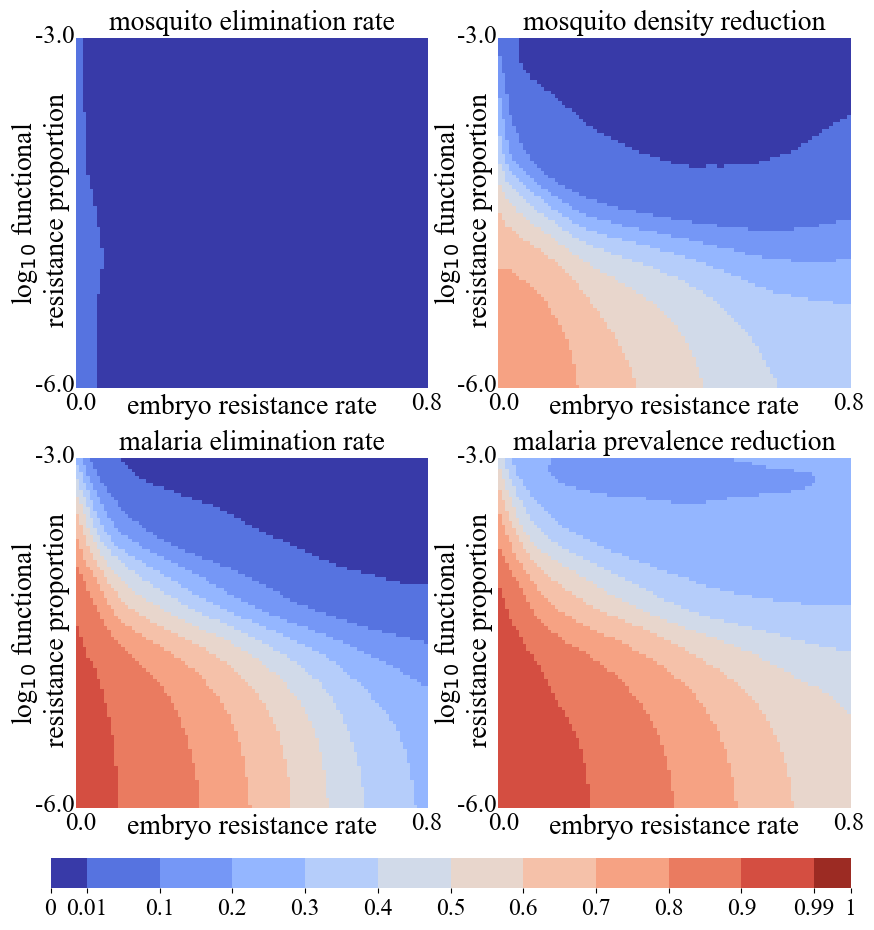

In [40]:
double_plot('embryo resistance rate','functional resistance proportion')

313/313 [==============================] - 0s 715us/step
[0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 22]


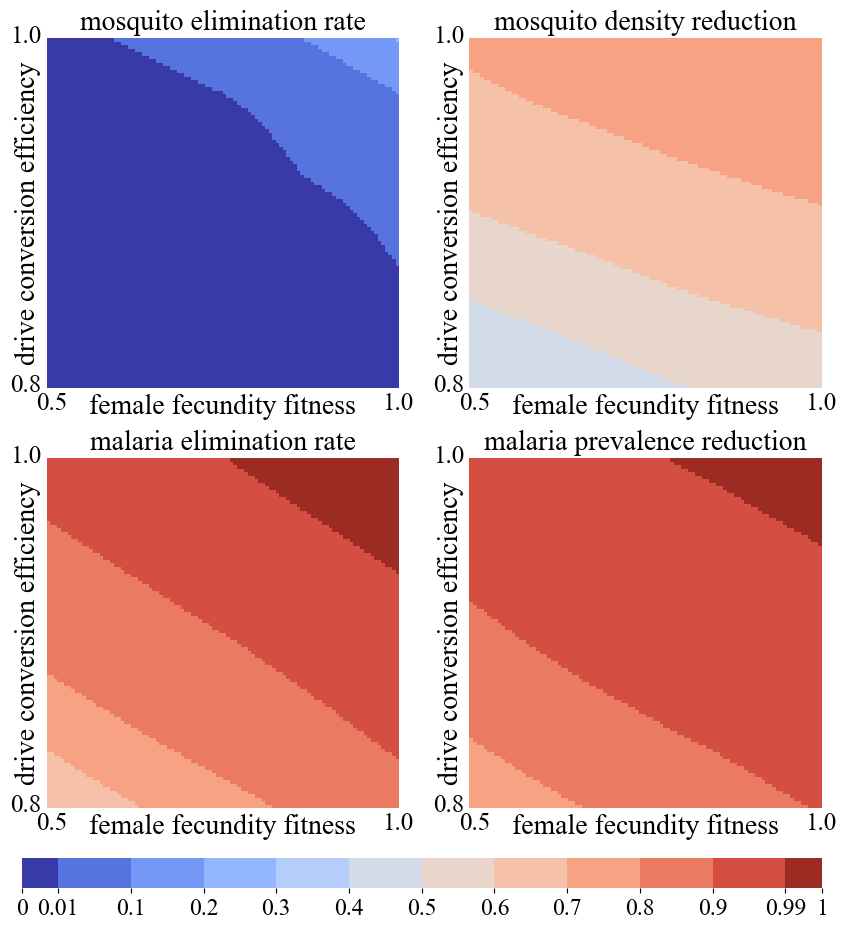

In [49]:
double_plot('drive conversion efficiency','female fecundity fitness')

313/313 [==============================] - 0s 817us/step
[0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 22]


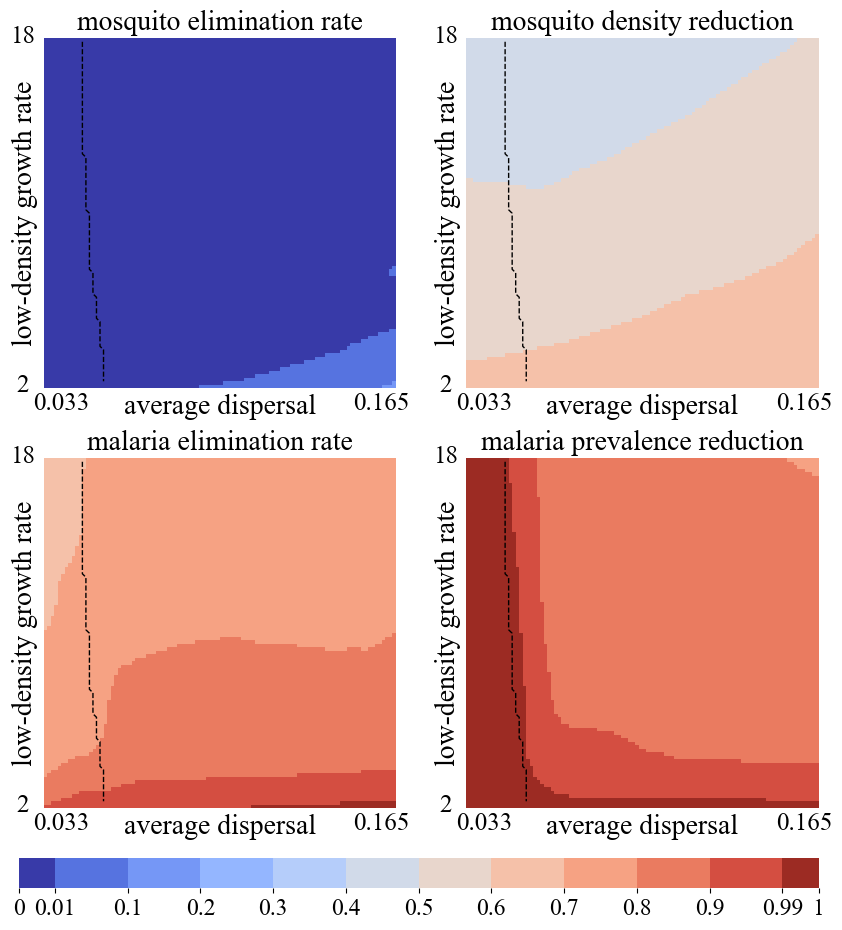

In [50]:
double_plot('low-density growth rate','average dispersal')

313/313 [==============================] - 0s 711us/step
[0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 22]


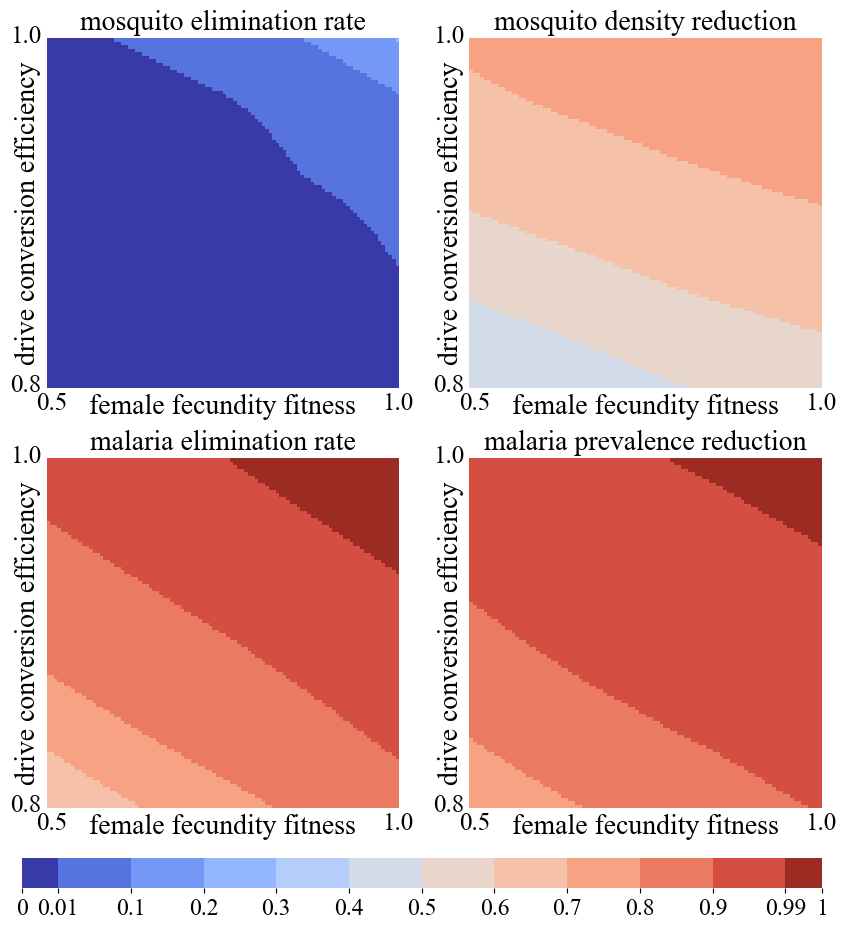

313/313 [==============================] - 0s 728us/step
[0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 22]


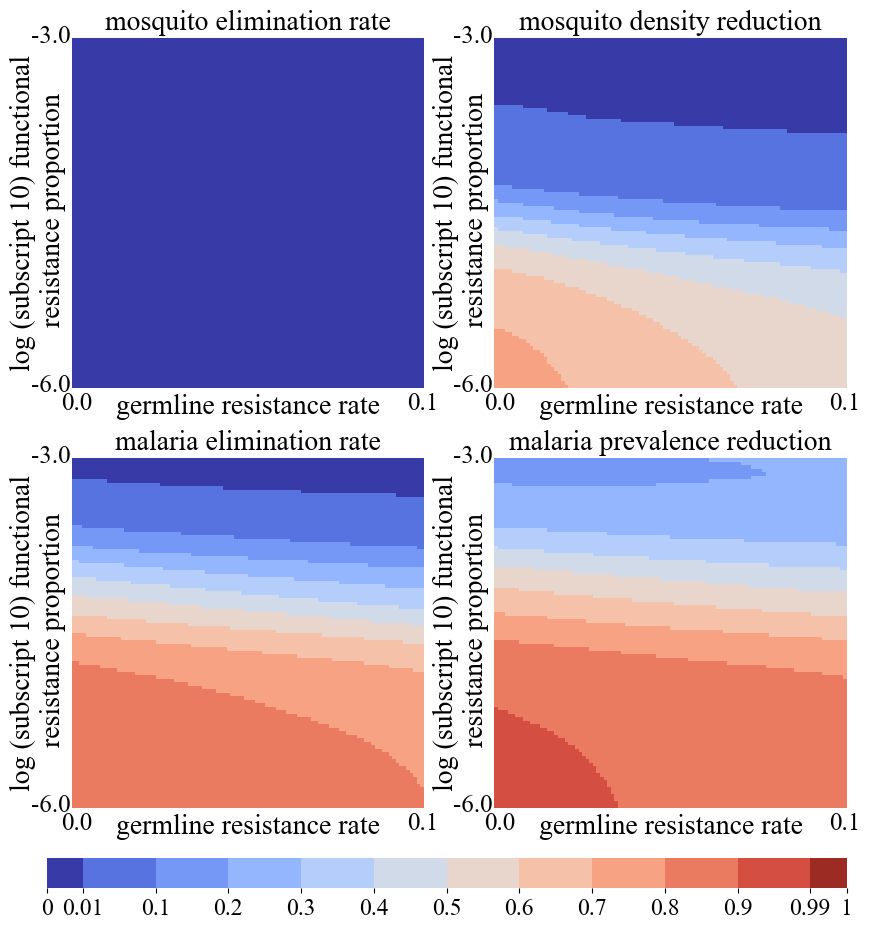

313/313 [==============================] - 0s 855us/step
[0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 22]


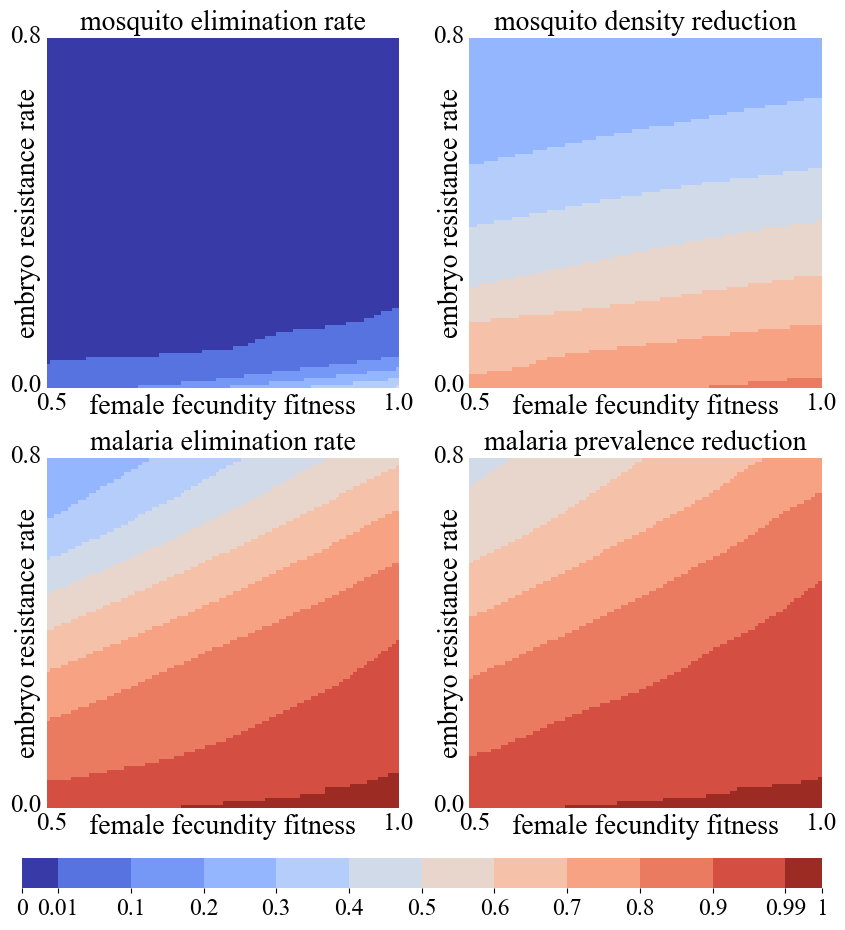

313/313 [==============================] - 0s 856us/step
[0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 22]


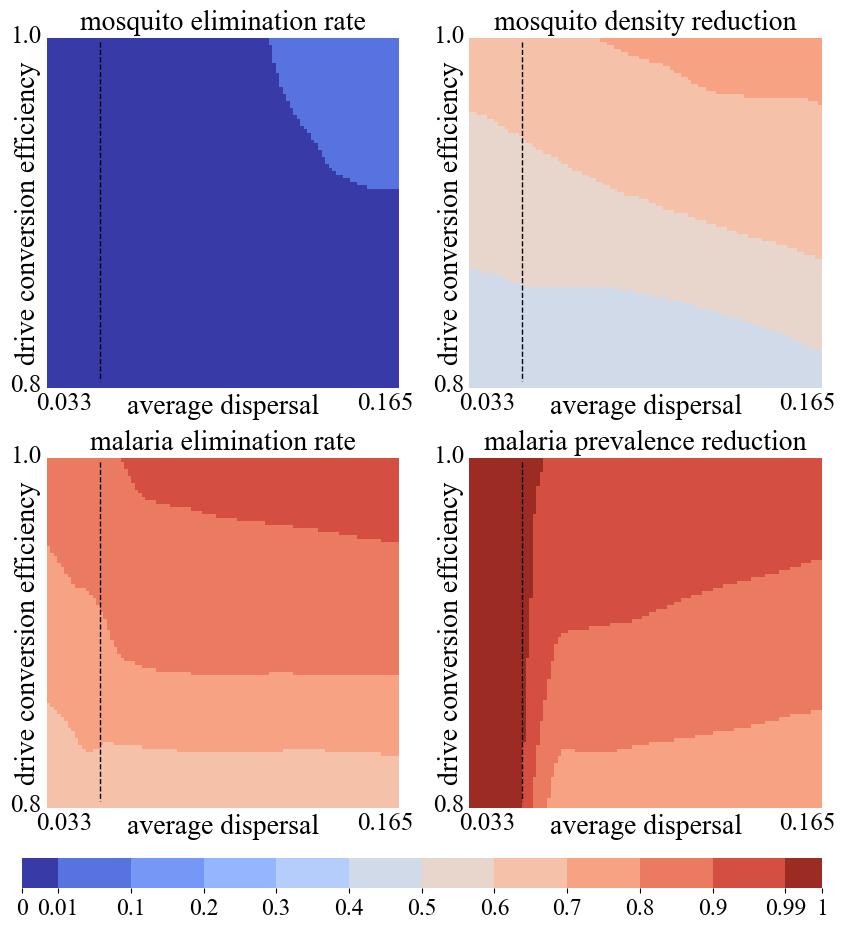

313/313 [==============================] - 0s 856us/step
[0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 22]


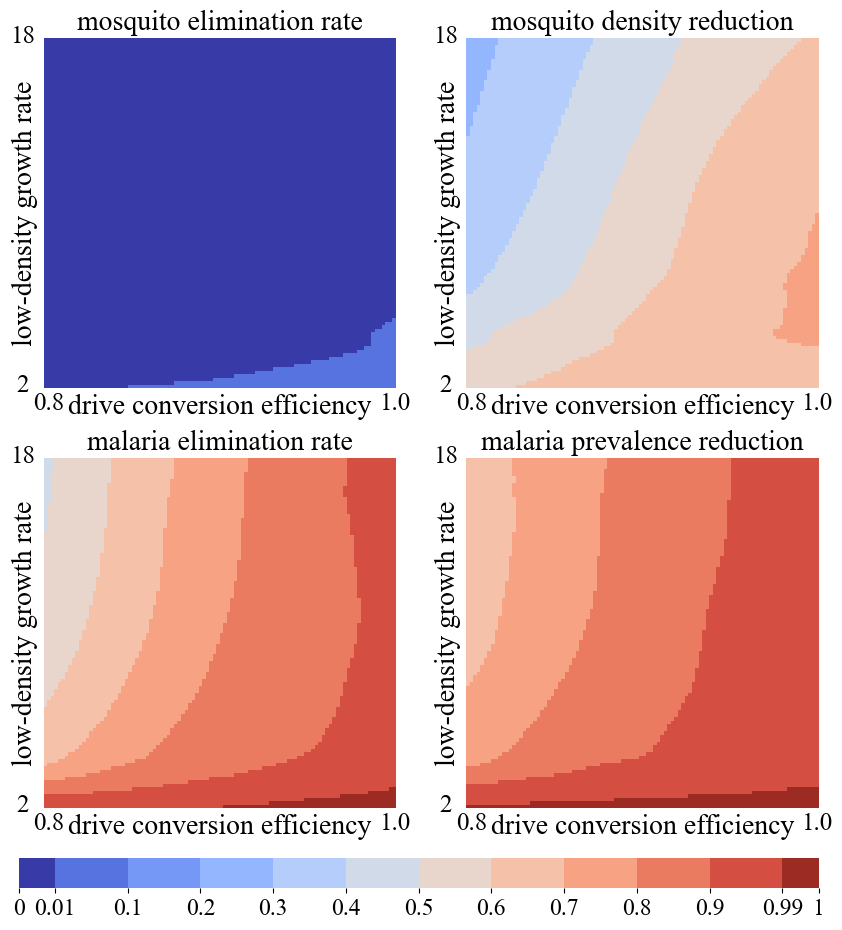

313/313 [==============================] - 0s 808us/step
[0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 22]


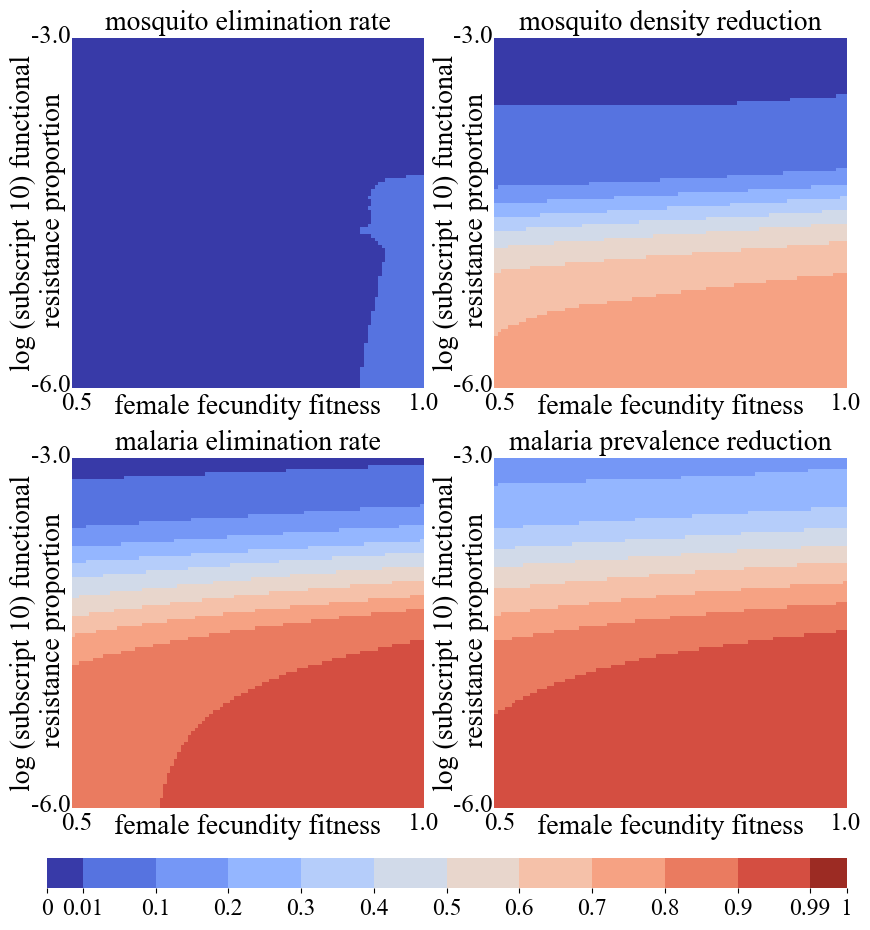

313/313 [==============================] - 0s 819us/step
[0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 22]


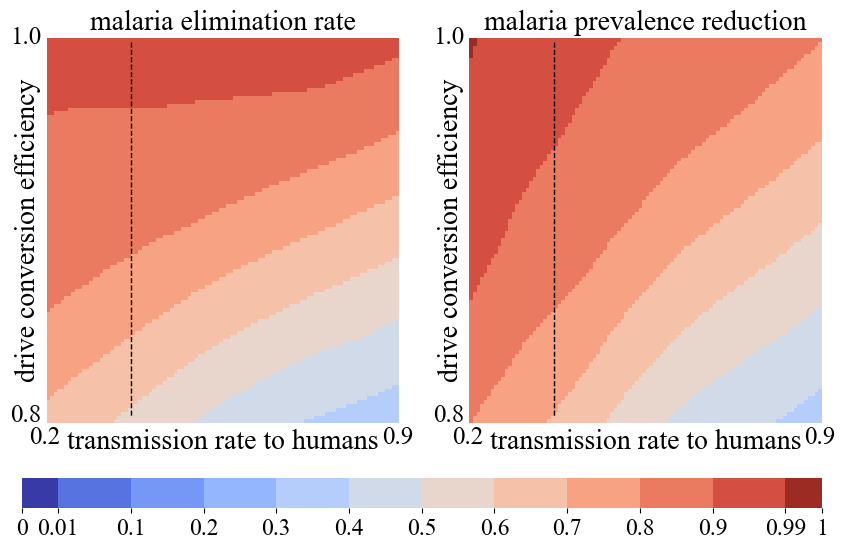

313/313 [==============================] - 0s 754us/step
[0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 22]


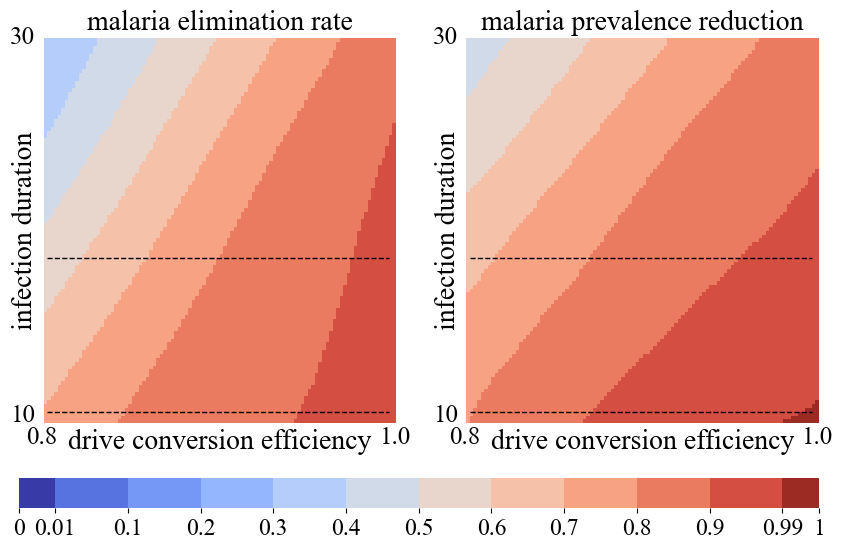

313/313 [==============================] - 0s 803us/step
[0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 22]


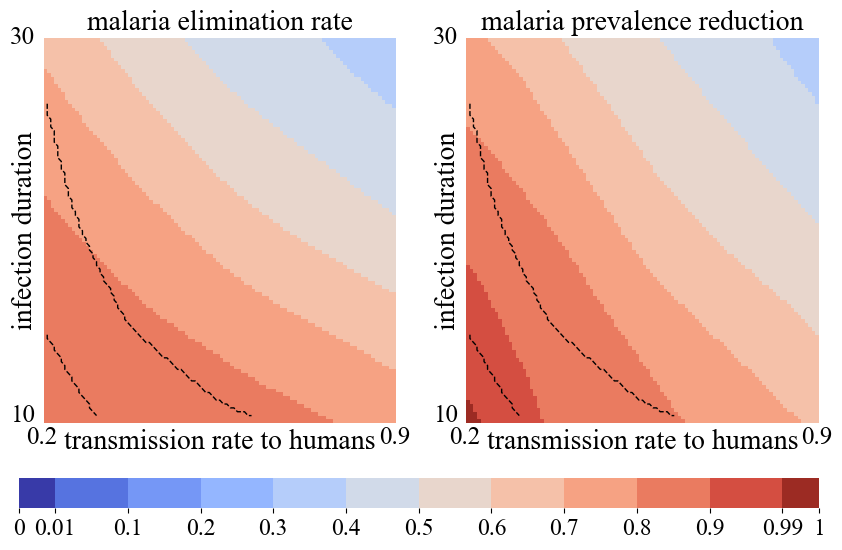

In [39]:
double_plot('drive conversion efficiency','female fecundity fitness')

double_plot('female fecundity fitness','embryo resistance rate')
double_plot('drive conversion efficiency','average dispersal')
double_plot('drive conversion efficiency','low-density growth rate')

double_plot('drive conversion efficiency','transmission rate to humans')
double_plot('drive conversion efficiency','infection duration')
double_plot('transmission rate to humans','infection duration')

313/313 [==============================] - 0s 932us/step
[0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 22]


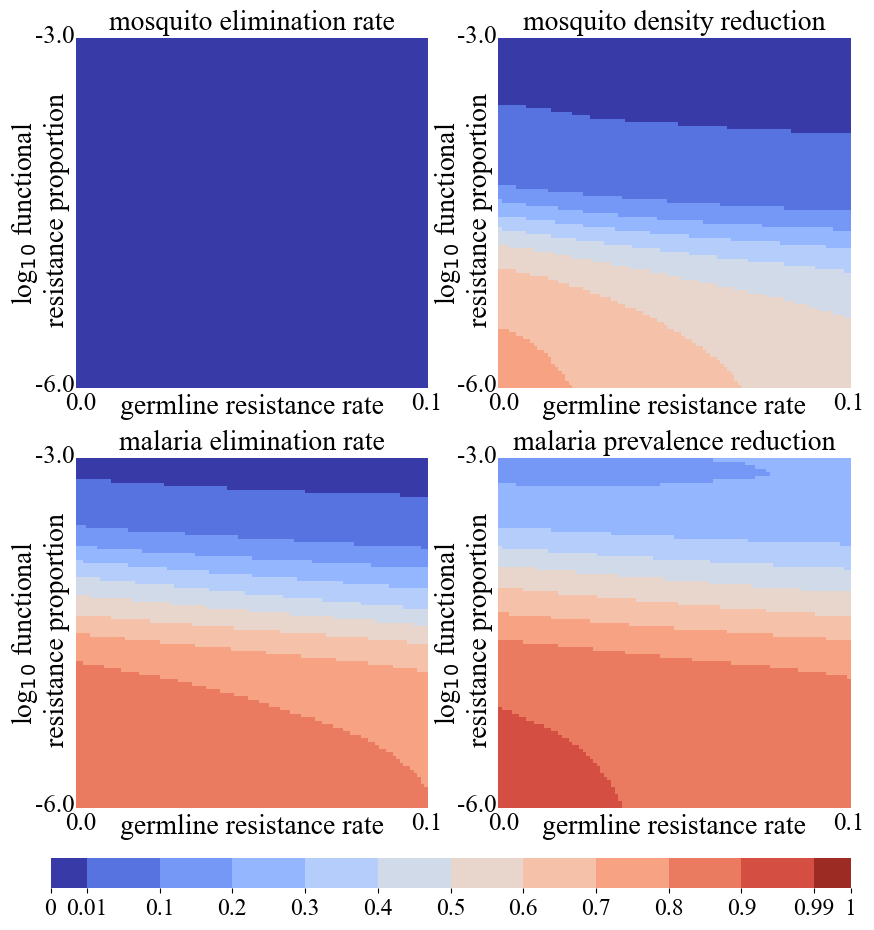

313/313 [==============================] - 0s 857us/step
[0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 22]


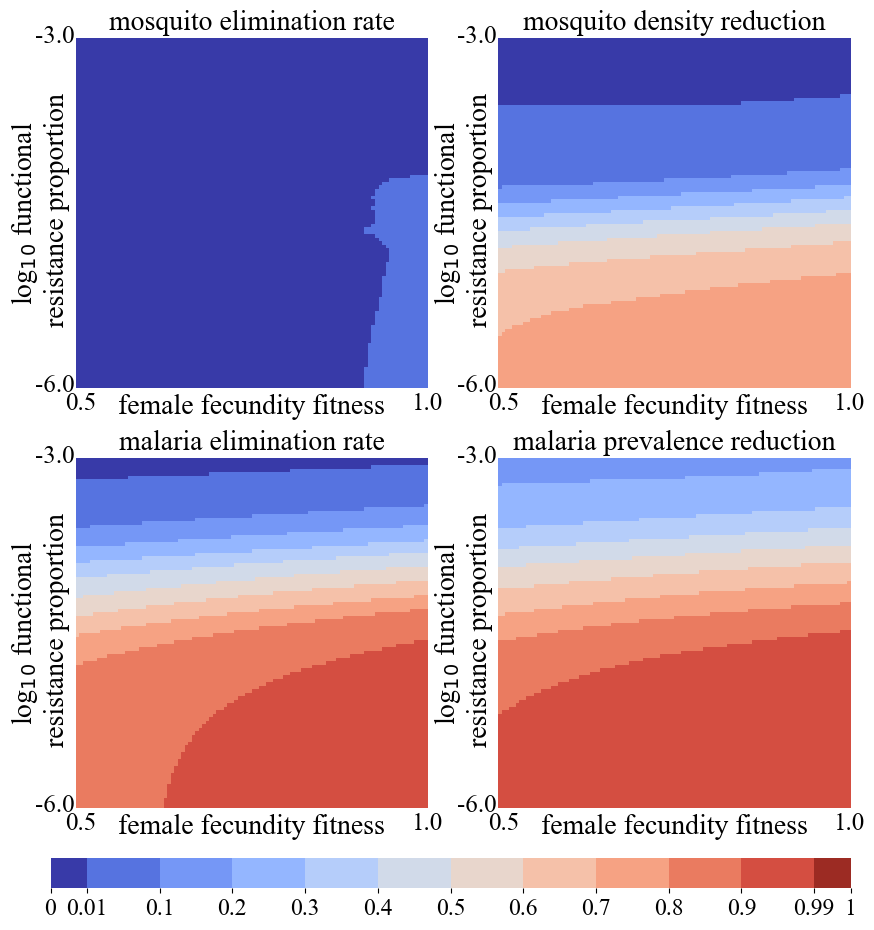

In [41]:
double_plot('germline resistance rate','functional resistance proportion')
double_plot('female fecundity fitness','functional resistance proportion')

313/313 [==============================] - 0s 1ms/step
[0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 22]


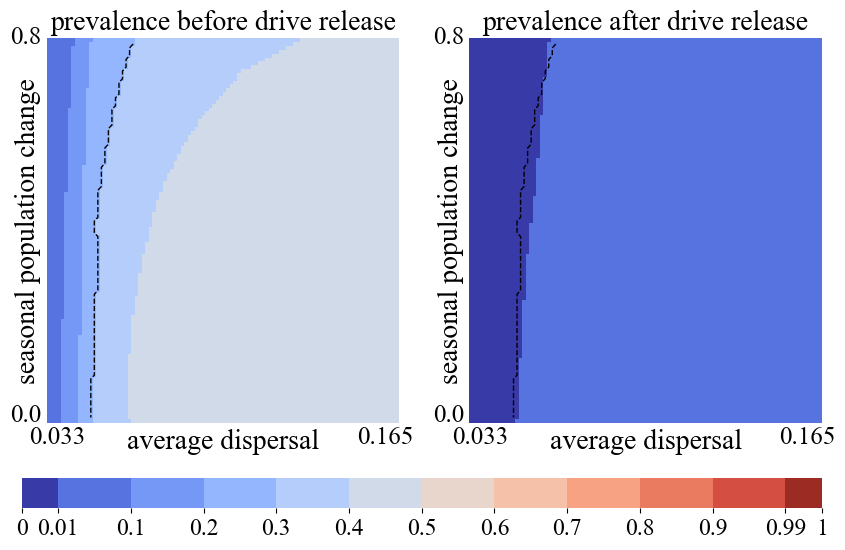

In [33]:
initial_plot('seasonal population change','average dispersal')

313/313 [==============================] - 0s 1ms/step
[0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 22]


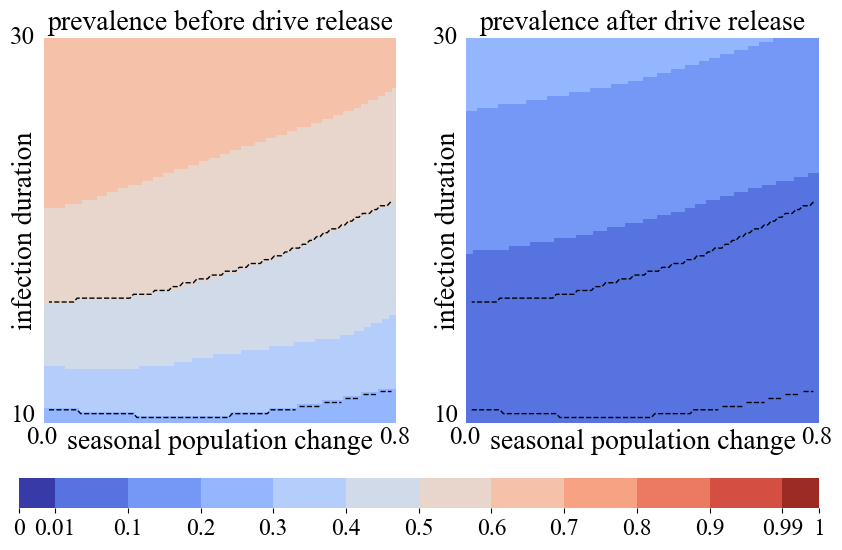

In [59]:
initial_plot('infection duration','seasonal population change')

313/313 [==============================] - 0s 984us/step
[0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 22]


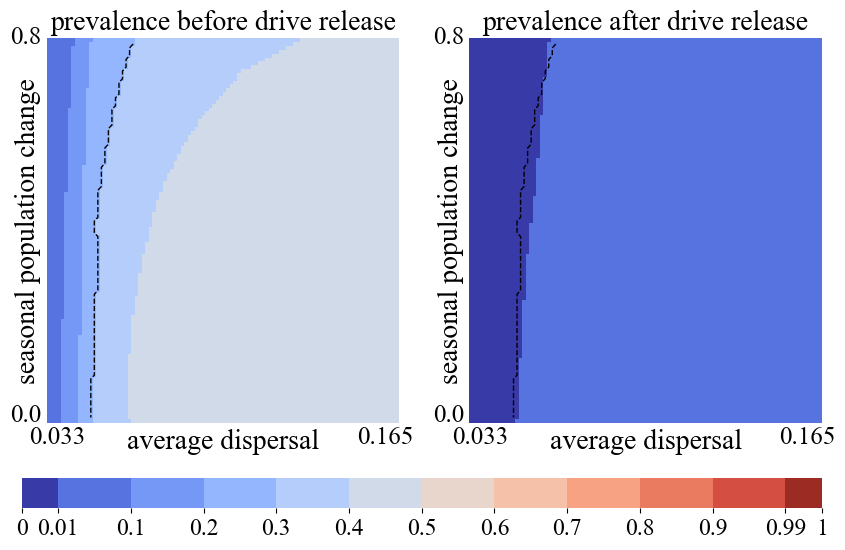

In [34]:
initial_plot('seasonal population change','average dispersal')

313/313 [==============================] - 0s 756us/step
[0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 22]


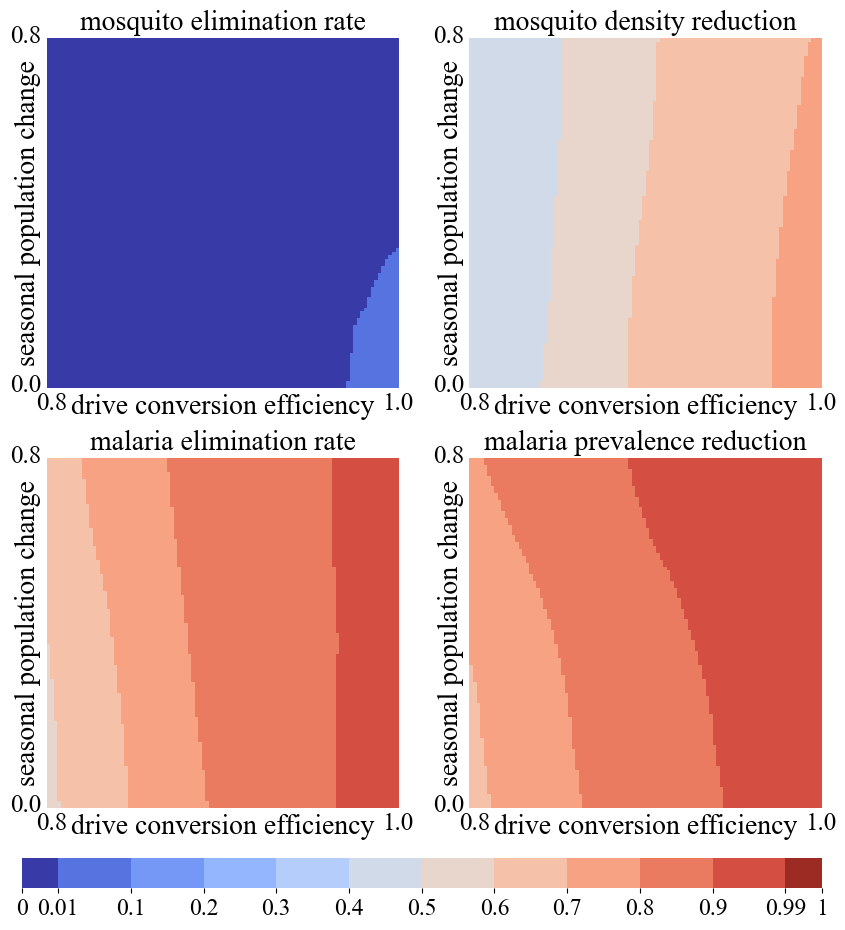

In [48]:
double_plot('drive conversion efficiency','seasonal population change')

In [55]:
#double_plot('low-density growth rate','seasonal population change') # old data don't run this line

313/313 [==============================] - 0s 738us/step
[0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 22]


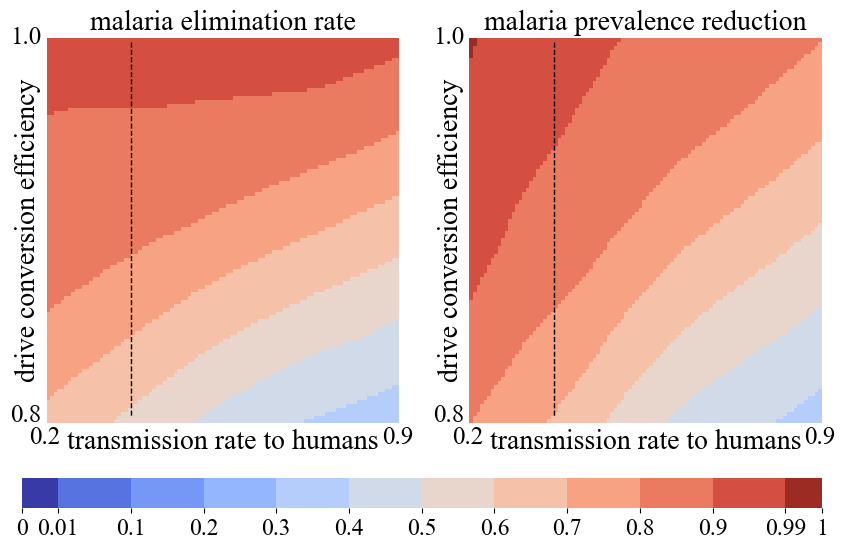

313/313 [==============================] - 0s 769us/step
[0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 22]


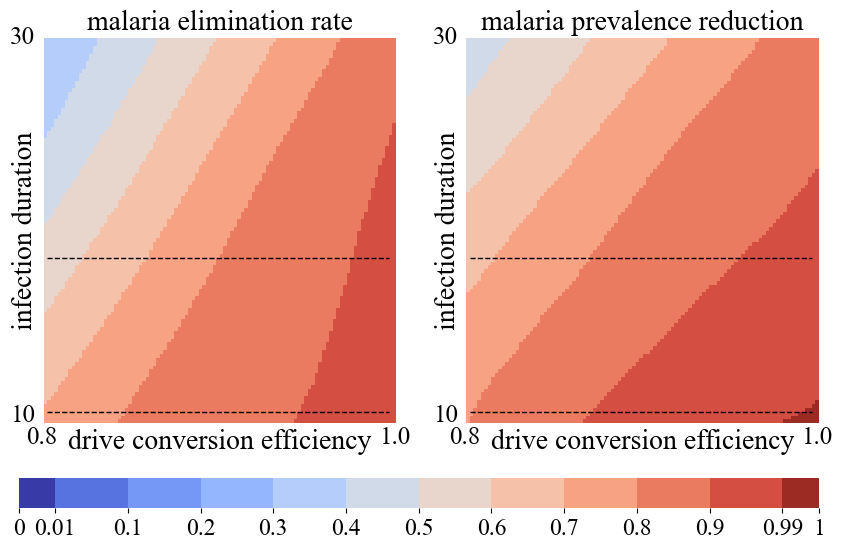

313/313 [==============================] - 0s 760us/step
[0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 22]


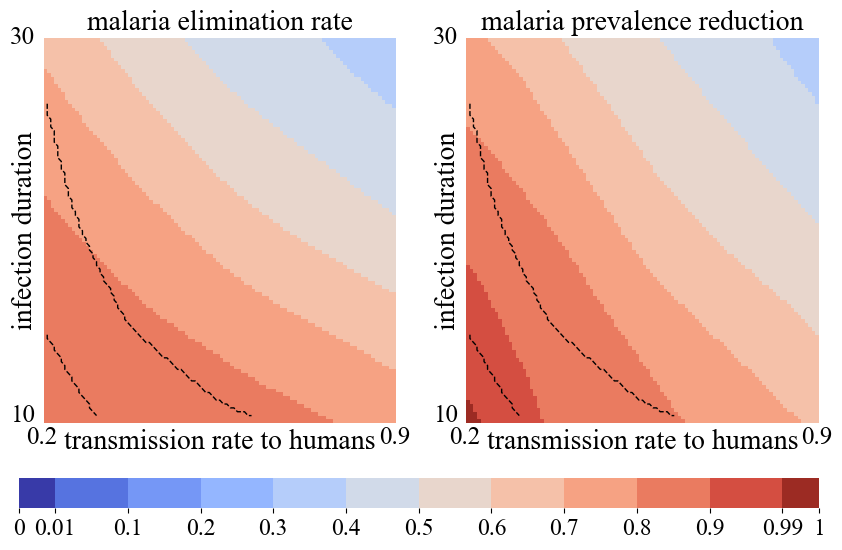

In [47]:
double_plot('drive conversion efficiency','transmission rate to humans')
double_plot('drive conversion efficiency','infection duration')
double_plot('transmission rate to humans','infection duration')